# P2 Exploration 

Basic exploration will be done in this jupyter notebook. Our exploration is divided into 4 major parts generally and based on the primary events we considered : 
- General exploration
- Feminism
- Space exploration 
- WW2

We would like to finetune DistilBERT on our dataset in order to determine whether movie passed the bechdel test or not:
https://huggingface.co/docs/transformers/en/tasks/sequence_classification 

helpers.py file has intermediate functions that helps us write some code.



In [ ]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
 
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
file_source = "/Users/shrinidhivelan/Downloads/"

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
reviews_path = "/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv"

# replace the following by the direct path of where your bechdel test movie data is:
bechdel_path = "/Users/shrinidhivelan/Downloads/movies.csv"

### creating dataset by extracting the main CMU data 
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_df = create_datasets(file_source, reviews_path)
reviews = pd.read_csv(reviews_path)

## 0) General exploration

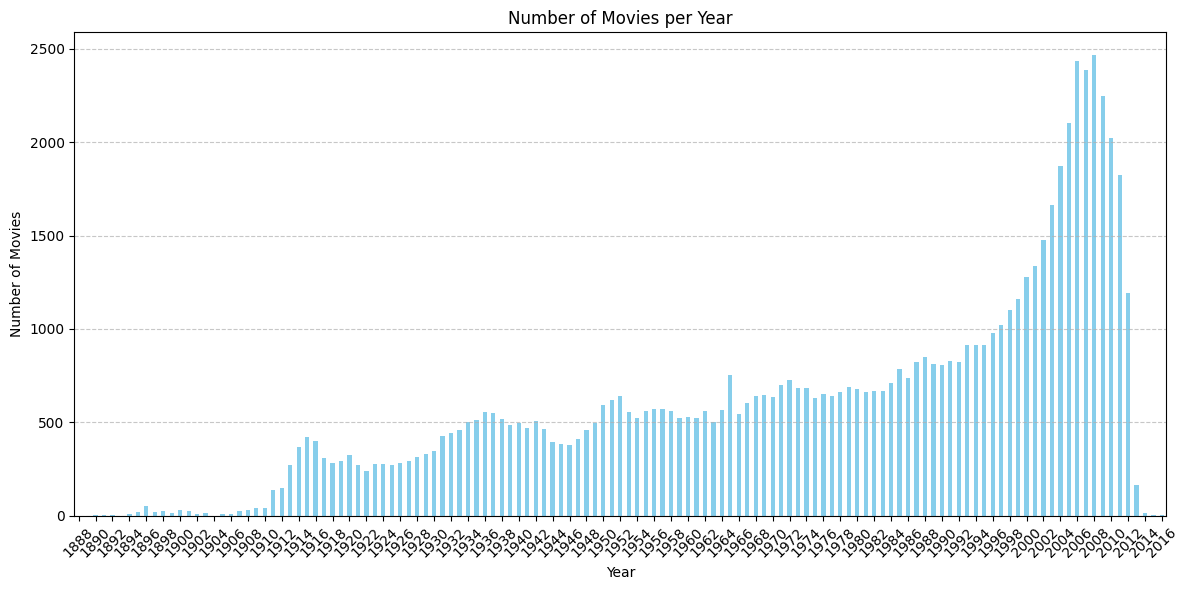

In [4]:
# Count the number of movies per year, ignoring NaN years
movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Set the x-ticks to display only every 2nd or 3rd year
plt.xticks(ticks=range(0, len(movies_per_year), 2), labels=movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1) Feminism

### Initial analysis and first steps towards labelling using ML

#### We merge the data on the bechdel test : 
following the ideas of the following site 
https://ai.plainenglish.io/predicting-bechdel-test-score-using-machine-learning-7253618a3f8

In [6]:
# The bechdel data contains ~1700 lines, to be separated into train and test sets in order to create a model to predict the binary result
#### 80% train and 20% test for instance, this will be used to merge main data into this : 
bechdel_data = pd.read_csv(bechdel_path)
bechdel_data = bechdel_data[['year', 'title', 'binary','budget']]
bechdel_data_merged = bechdel_data.merge(MovieMetadata_df, how='left', left_on = 'title', right_on = 'Movie name')

# Define the columns to check for NaN values
columns_to_check = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 
    'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Remove rows where all specified columns are NaN
bechdel_data_merged = bechdel_data_merged.dropna(subset=columns_to_check, how='all')

# Display the DataFrame to confirm rows are removed - around ~300 lines are removed
#display(bechdel_data_merged)

####  a) Using the RF classifier

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = bechdel_data_merged  

target = 'result'
features = [
    'year', 'budget', 'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)', 'Year'
]

# Convert 'FAIL' to 0 and 'PASS' to 1 in the 'binary' column
df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


# Drop rows where target is NaN
df = df.dropna(subset=[target])

# Separate features and target variable (X and y constantly)
X = df[features]
y = df[target]

# Define which columns need specific preprocessing
numeric_features = ['year', 'budget', 'Movie box office revenue', 'Movie runtime', 'Year']
categorical_features = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Define preprocessors for a simple random forests  model : 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)#, random_state=42)

# Define and train the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])#(random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_77672/1462372775.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


Accuracy: 0.59
F1 Score: 0.45
ROC AUC Score: 0.58
